In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torchvision

# dataset preparation
import torchvision.transforms as transforms

# NN
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models as torch_models

from torchsummary import summary

# Utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Other
import os
import zipfile
import requests
import hashlib
import random
import time
import datetime
import json
import zipfile
import PIL
from PIL import Image

np.random.seed(5051)

device = "cuda" if torch.cuda.is_available() else "cpu"


num_embeddings = 10000 # look num_words in file "prepare_ds.py"
                             # or it must be len(SrachSet.mydict.keys()) == 229520 ???

# Подготовка датасета

Надо что-нибудь написать... Потом... Как-нибудь...

In [3]:
class SrachSet(torch.utils.data.Dataset):
    mydict = None
    
    def __init__(self, _type: str, _path: str = "out.zip", _json_path: str = "word_index_dict.json"):
        self.__type = _type
        assert self.__type in ["train", "valid", "test"]
        self.mypath = _path
        self.mypath_dict = _json_path
        self.laeblo = []
        self.myds = []
        
        __z = zipfile.ZipFile(self.mypath)
        df_str_fs = __z.open("out.csv")
        df = pd.read_csv(df_str_fs)
        df = df.reset_index()
        for i, row_i in df.iterrows():
            self.laeblo.append(   [row_i["toxics"], row_i["obscene"], row_i["threat"], row_i["insult"], row_i["identity_hate"]]   )
            self.myds.append  (   list(map(int, str(row_i["comment"]).split()))   )
        
        self.mydss = [(i, j) for i, j in zip(self.myds, self.laeblo)]
        #random.shuffle(self.mydss)

        if(self.__type == "train"):
            #self.myds = self.__split_ds(self.myds)[0]
            #self.laeblo = self.__split_ds(self.laeblo)[0]
            self.mydss = self.__split_ds(self.mydss)[0]
        elif(self.__type == "valid"):
            #self.myds = self.__split_ds(self.myds)[1]
            #self.laeblo = self.__split_ds(self.laeblo)[1]
            self.mydss = self.__split_ds(self.mydss)[1]
        elif(self.__type == "test"):
            #self.myds = self.__split_ds(self.myds)[2]
            #self.laeblo = self.__split_ds(self.laeblo)[2]
            self.mydss = self.__split_ds(self.mydss)[2]
        else:
            raise Exception("wtf")
        random.shuffle(self.mydss)

        if(SrachSet.mydict == None):
            S = None
            with open(self.mypath_dict, 'r', encoding="utf-8") as temp:
                S = temp.read()
            buff = json.loads(S)
            SrachSet.mydict = {v: k for k, v in buff.items()}
        
    def __split_ds(self, a: list) -> "(list, list, list)":
        split_num = int(0.7*len(a) +0.5)
        train = a[:split_num]               # 70 %
        test_and_valid  = a[split_num:]     # 30 %
        
        split_num = int((1/3)*len(test_and_valid) +0.5)
        valid = test_and_valid[:split_num]  # 10% = 1/3 * 30%
        test = test_and_valid[split_num:]   # 20% = 2/3 * 30%
        return (train, valid, test)

    def __len__(self):
        #return len(self.myds)
        return len(self.mydss)

    def __getitem__(self, idx):
        #cur = self.myds[idx]
        #wa  = self.laeblo[idx]
        cur, wa = self.mydss[idx]

        #tenz_cur = torch.LongTensor(cur)
        #cur = torch.Tensor(cur)
        cur = torch.IntTensor(cur)
        wa = torch.IntTensor(wa)
        
        return cur, wa

    def convert_tensor_to_label(tensor: "Tensor"):
        res = ["toxics: ", "obscene: ", "threat: ", "insult: ", "identity_hate: "]
        li = 0
        for el_i in tensor:
            if el_i != 0:
                res[li] = res[li] + "yes"
            else:
                res[li] = res[li] + "no"
            li-=-1
        
        return res

    def show_seq(seq_tensor: "Tensor") -> str:
        S = ""
        for item_i in seq_tensor:
            kye = int(item_i)
            if(kye != 0):
                S += f"{SrachSet.mydict[kye]} "
        return S

    def get_label_dict() -> dict:
        return {"toxics": 0, "obscene": 0, "threat": 0, "insult": 0, "identity_hate": 0}

In [4]:
# функция инициализации датасетлоудеров:
trainloader, validloader, testloader = None, None, None
def dsloaders_init(batch_size):
    num_workers = 1
    global trainloader
    global validloader
    global testloader
    mytrainset = SrachSet("train")
    trainloader = torch.utils.data.DataLoader(mytrainset, batch_size=batch_size, num_workers=num_workers)

    myvalidset = SrachSet("valid")
    validloader = torch.utils.data.DataLoader(myvalidset, batch_size=batch_size, num_workers=num_workers)

    mytestset = SrachSet("test")
    testloader = torch.utils.data.DataLoader(mytestset, batch_size=batch_size, num_workers=num_workers)

In [5]:
# функция показа содержимого
def show_srach(srach_rensor: "Tensor", label_tensor: "Tensor") -> None:
    srach_list = [int(i) for i in srach_rensor]
    print(srach_list)
    print("<--->")
    print(SrachSet.show_seq(srach_rensor))
    print(f"It is: {SrachSet.convert_tensor_to_label(label_tensor)}")
    print("\n\n")

In [6]:
dsloaders_init(16)

In [7]:
# получаем несколько случайных обучающих $%#5^
dataiter = iter(trainloader)
seqs_tenz, labels_tenz = next(dataiter)

for seq_tenz_i, label_tenz_i in zip(seqs_tenz, labels_tenz):
    show_srach(seq_tenz_i, label_tenz_i)

[9141, 102, 16, 410, 1076, 9738, 884, 38, 2160, 47, 220, 10, 90, 146, 485, 43, 95, 2674, 2, 16, 36, 8, 1076, 5257, 938]
<--->
consensual could be considered sexual battery 19 what rubbish no person in their right mind would even dare to be so is sexual assault period 
It is: ['toxics: no', 'obscene: no', 'threat: no', 'insult: no', 'identity_hate: no']



[10, 1, 582, 172, 196, 2, 349, 64, 6, 229, 2804, 234, 16, 903, 26, 22, 6, 79, 6, 814, 1117, 518, 1701, 471, 126]
<--->
in the future you're welcome to post here i can't promise i'll be online but if i am i usually respond pretty quickly happy editing 
It is: ['toxics: no', 'obscene: no', 'threat: no', 'insult: no', 'identity_hate: no']



[4, 5, 882, 6, 65, 5, 343, 7, 68, 12, 5, 16, 1459, 5, 4440, 43, 16, 5, 97, 419, 22, 5, 228, 773, 46]
<--->
and a personally i think a bit you know for a be bold a pink would be a good start if a little obvious talk 
It is: ['toxics: no', 'obscene: no', 'threat: no', 'insult: no', 'identity_hate: no']

In [8]:
# получаем несколько случайных валидационных ?!№#@
dataiter = iter(validloader)
seqs_tenz, labels_tenz = next(dataiter)

for seq_tenz_i, label_tenz_i in zip(seqs_tenz, labels_tenz):
    show_srach(seq_tenz_i, label_tenz_i)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 407, 2522, 13, 56, 16, 3666]
<--->
oh lord this should be sexy 
It is: ['toxics: no', 'obscene: no', 'threat: no', 'insult: no', 'identity_hate: no']



[36, 6, 226, 52, 293, 11, 6, 226, 11, 147, 25, 337, 6, 8747, 19, 2, 123, 677, 59, 988, 53, 3766, 3, 87, 18]
<--->
so i hope he got it i hope it over or else i ll have to go kill some children which si of them are 
It is: ['toxics: no', 'obscene: no', 'threat: no', 'insult: no', 'identity_hate: no']



[35, 794, 74, 110, 1424, 7, 435, 453, 156, 920, 174, 5, 4, 6364, 27, 78, 525, 48, 16, 1564, 25, 48, 16, 1591, 93]
<--->
about living people wp blp you cannot call someone dead without a and preferably an edit summary please be constructive or please be elsewhere thanks 
It is: ['toxics: no', 'obscene: no', 'threat: no', 'insult: no', 'identity_hate: no']



[22, 7, 136, 55, 3016, 9, 121, 2, 16, 203, 15, 1, 23, 89, 151, 59, 2639, 70, 3, 67, 6968, 48, 96, 87, 652]
<--->
if you find a

In [9]:
# получаем несколько случайных тестовых %1№2!#?
dataiter = iter(testloader)
seqs_tenz, labels_tenz = next(dataiter)

for seq_tenz_i, label_tenz_i in zip(seqs_tenz, labels_tenz):
    show_srach(seq_tenz_i, label_tenz_i)

[173, 5, 2900, 2, 9406, 9, 59, 106, 389, 8455, 22, 99, 57, 1308, 2, 34, 4144, 52, 756, 16, 5, 803, 108, 89, 1978]
<--->
added a footnote to acknowledging that some sources claim 1942 if had been willing to do likewise he wouldn't be a banned user now '''' 
It is: ['toxics: no', 'obscene: no', 'threat: no', 'insult: no', 'identity_hate: no']



[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 424, 46, 441, 3935, 10, 7012, 706]
<--->
redirect talk listed buildings in rural area 
It is: ['toxics: no', 'obscene: no', 'threat: no', 'insult: no', 'identity_hate: no']



[3507, 1217, 2, 765, 6684, 480, 4, 36, 34, 274, 36, 243, 10, 485, 9, 11, 8, 49, 5, 1941, 14, 1, 1137, 526, 1462]
<--->
dozen ways to avoid cu myself and so do others so keep in mind that it is just a tool not the final answer join 
It is: ['toxics: no', 'obscene: no', 'threat: no', 'insult: no', 'identity_hate: no']



[0, 0, 0, 0, 0, 0, 0, 302, 1827, 4, 40, 24, 6, 1843, 9, 3565, 187, 19, 27, 23, 15, 1, 258, 659, 37]
<-

In [10]:
# Смотрим, что вообще есть видеокарта

print(f"CUDA? {torch.cuda.is_available()}")
print(f"Devices count: {torch.cuda.device_count()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device: {torch.cuda.device(0)}")
print(f"GPU name: {torch.cuda.get_device_name(0)}")
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


CUDA? True
Devices count: 1
Current device: 0
Device: <torch.cuda.device object at 0x7fa1be4062f0>
GPU name: NVIDIA GeForce GTX 1070 Ti
Allocated: 0.0 GB
Cached:    0.0 GB


# Делаем собственную архитектуру

## Обучающий класс

In [6]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):

        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.train_accur = []
        self.val_accur = []
        
    def train_step(self, x, y, correct_answer: dict, all_answer: dict) -> "(loss, correct_answer, all_answer)":
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        correct_answer, all_answer = fill_dict(yhat, y, correct_answer, all_answer)
        
        # Computes loss
        loss = self.loss_fn(yhat, y)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return (loss.item(), correct_answer, all_answer)

    def train(self, train_loader, val_loader, n_epochs, test_loader = None) -> None:
        for epoch in range(1, n_epochs + 1):
            
            batch_losses = []
            correct_answer, all_answer = SrachSet.get_label_dict(), SrachSet.get_label_dict()
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device).float()
                loss, correct_answer, all_answer = self.train_step(x_batch, y_batch, correct_answer, all_answer)
                batch_losses.append(loss)
                
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)
            epoch_train_accur = calc_accur(correct_answer, all_answer)
            self.train_accur.append(epoch_train_accur)

            with torch.no_grad():
                batch_val_losses = []
                correct_answer, all_answer = SrachSet.get_label_dict(), SrachSet.get_label_dict()
                for x_val, y_val in val_loader:
                    x_val, y_val = x_val.to(device), y_val.to(device).float()
                    self.model.eval()
                    yhat = self.model(x_val)
                    correct_answer, all_answer = fill_dict(yhat, y_val, correct_answer, all_answer)
                    val_loss = self.loss_fn(yhat, y_val).item()
                    batch_val_losses.append(val_loss)
                    
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
                epoch_val_accur = calc_accur(correct_answer, all_answer)
                self.val_accur.append(epoch_val_accur)
            
            print(f"({epoch}/{n_epochs}) train: (loss: {training_loss}, accur: {epoch_train_accur}), val: (loss: {validation_loss}, accur: {epoch_val_accur})")

    def evaluate(self, test_loader) -> "(predicted, values)":
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                self.model.eval()         # dropout is here, so call it
                yhat = self.model(x_test)
                predictions.append(yhat.to("cpu").detach().numpy())
                values.append(y_test.to("cpu").detach().numpy())

        return predictions, values
    
    def plot_losses(self):
        """The method plots the calculated loss values for training and validation
        """
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()
        
        plt.plot(self.train_accur, label="Training accuracy")
        plt.plot(self.val_accur, label="Validation accuracy")
        plt.legend()
        plt.title("Accuracy")
        plt.show()
        plt.close()

def fill_dict(pred_i: "Tensor: (xs)", real_i: "Tensor: (xs)", correct_answer: dict, all_answer: dict) -> "(correct_answer, all_answer)":
    '''Tensor: (xs) mean: It is Tensor with answers of NN of one batch'''
    for pred_i_j, real_i_j in zip(pred_i, real_i): # Перебираем высер сети и ответы
        for pred_i_j_k, real_i_j_k, key_k in zip(pred_i_j, real_i_j, all_answer):
            pred_i_j_k_01 = 0 if pred_i_j_k < 0.5 else 1
            if(pred_i_j_k_01 == real_i_j_k):
                correct_answer[key_k] += 1
            all_answer[key_k] += 1
    
    return (correct_answer, all_answer)

def calc_accur(correct_answer: dict, all_answer: dict, ifprint: bool = False) -> float:
    avg = 0
    for key_i in correct_answer:
        avg_i = round(100.0*(correct_answer[key_i]/all_answer[key_i]), 2)
        if(ifprint == True):
            print(f"{key_i}: {avg_i} %")
        avg += avg_i
    avg = round(avg/len(all_answer), 2)
    if(ifprint == True):
        print(f"avg: {avg} %")
    return avg

def get_accuracy(preds: "Tensor (N, xs)", reals: "Tensor (N, xs)", ifprint: bool = False) -> float:
    '''Tensor (N, x) mean: It is Tensor with dimention = (N, x), where N - Batch size, xs - predicts/answers'''

    correct_answer, all_answer = SrachSet.get_label_dict(), SrachSet.get_label_dict()


    for pred_i, real_i in zip(preds, reals): # Перебираем батчи
        correct_answer, all_answer = fill_dict(pred_i, real_i, correct_answer, all_answer)

    avg = calc_accur(correct_answer, all_answer, ifprint)
    return avg


## Архитектура 1

In [26]:
class SrachNet1(nn.Module):
    def __init__(self):
        self.hidden_size = 16
        self.num_layers = 25
        self.dropout_prop = 0.2
        self.vect_num = 4
        
        super(SrachNet1, self).__init__()
        self.em1  = nn.Embedding(num_embeddings, self.vect_num).to(device)
        # После Embedding каждый токен будет представляться как вектор в vect_num-ом пространстве
        
        self.rnn2 = nn.RNN(
            input_size=self.vect_num, hidden_size=self.hidden_size, num_layers=self.num_layers, 
            batch_first=True, dropout=self.dropout_prop
        ).to(device) # if batch_first=True expect input in=(N,L,Hin), h=(num_layers,N,Hout)
        #              N=batch_size, L=sequence_length, Hin=input_size, Hout=hidden_size
        #              if batch_first=True output (N, L, Hout)   (В данном примере L=25)
        #        https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        
        self.dance4 = nn.Linear(self.hidden_size, 5).to(device)
                      # 5 = len([toxics, obscene, threat, insult, identity_hate])

    def forward(self, sentence):
        batch_size = sentence.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(device)
        
        # sentence - лист c batch_size, где каждый элемент - это список токенов слов
        embeds = self.em1(sentence)
        # embeds - лист c batch_size, где каждый элемент - это список векторов слов
        
        out, h0 = self.rnn2(embeds, h0.detach()) # detach <-> will never require gradient.
        # embeds.shape = (batch_size, 25, self.vect_num)
        # h0.shape = (self.num_layers, batch_size, self.hidden_size)
        # out.shape = (batch_size, 25, self.hidden_size)

        out_s = out[:, -1, :]
        # out_s.shape = (batch_size, self.hidden_size)
        # (batch_size, 25, self.hidden_size) -> (batch_size, self.hidden_size), где hidden_size последний слой rnn
        
        x = self.dance4(out_s)
        return x

    def compute_l1_loss(self, w): # Так или Адомом. Правда у него только L2...
        return torch.abs(w).sum()
    def compute_l2_loss(self, w): # Так или Адомом
        return torch.square(w).sum()


In [50]:
dsloaders_init(256)

(1/3) train: (loss: 0.6561164008010001, accur: 88.92), val: (loss: 0.43364145172924934, accur: 95.47)
(2/3) train: (loss: 0.7616309559770993, accur: 89.68), val: (loss: 0.7874619902312001, accur: 95.75)
(3/3) train: (loss: 0.46302341385966256, accur: 92.24), val: (loss: 0.21910731513288956, accur: 95.75)


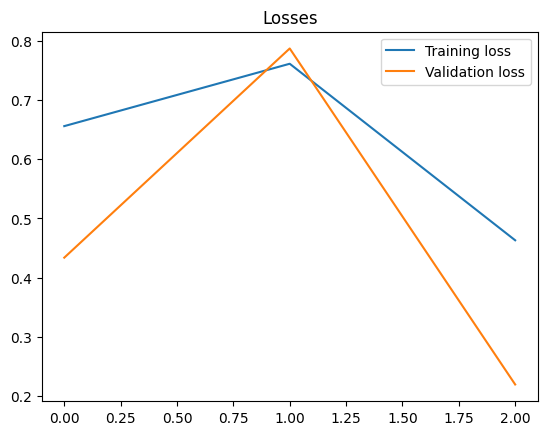

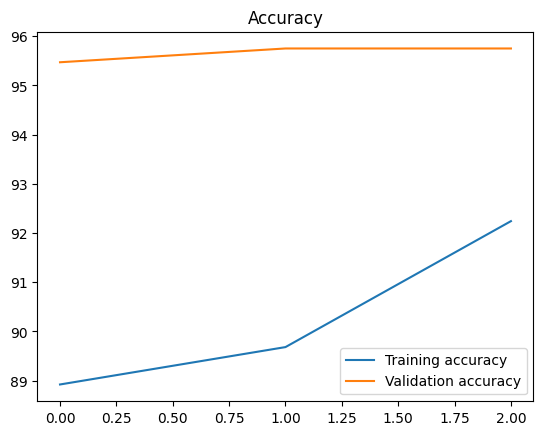

In [51]:
n_epochs = 3
learning_rate = 0.01
weight_decay = 0.01 # for L2

model = SrachNet1()
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCEWithLogitsLoss() # multilabel multiclass
#loss_fn = nn.BCELoss()
 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(trainloader, validloader, n_epochs)
opt.plot_losses()


In [52]:
preds, reals = opt.evaluate(testloader)
get_accuracy(preds, reals, ifprint=True)

toxics: 90.61 %
obscene: 94.49 %
threat: 99.73 %
insult: 94.9 %
identity_hate: 99.07 %
avg: 95.76 %


95.76

## Архитектура 2

In [38]:
class SrachNet2(nn.Module):
    def __init__(self):
        self.hidden_size = 16
        self.num_layers = 25
        self.dropout_prop = 0.2
        self.vect_num = 4
        
        super(SrachNet2, self).__init__()
        self.em1  = nn.Embedding(num_embeddings, self.vect_num).to(device)
        # После Embedding каждый токен будет представляться как вектор в vect_num-ом пространстве
        
        self.lstm2 = nn.LSTM(
            input_size=self.vect_num, hidden_size=self.hidden_size, num_layers=self.num_layers, 
            batch_first=True, dropout=self.dropout_prop
        ).to(device) # if batch_first=True expect input in=(N,L,Hin), h=(num_layers,N,Hout)
        #              N=batch_size, L=sequence_length, Hin=input_size, Hout=hidden_size
        #              if batch_first=True output (N, L, Hout)   (В данном примере L=25)
        #        https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        
        self.dance4 = nn.Linear(self.hidden_size, 5).to(device)
                      # 5 = len([toxics, obscene, threat, insult, identity_hate])

    def forward(self, sentence):
        batch_size = sentence.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(device)
        
        # sentence - лист c batch_size, где каждый элемент - это список токенов слов
        embeds = self.em1(sentence)
        # embeds - лист c batch_size, где каждый элемент - это список векторов слов
        
        out, h0 = self.lstm2(embeds, (h0.detach(), c0.detach())) # detach <-> will never require gradient.
        # embeds.shape = (batch_size, 25, self.vect_num)
        # h0.shape = (self.num_layers, batch_size, self.hidden_size)
        # c0.shape = (self.num_layers, batch_size, self.hidden_size)
        # out.shape = (batch_size, 25, self.hidden_size)

        out_s = out[:, -1, :]
        # out_s.shape = (batch_size, self.hidden_size)
        # (batch_size, 25, self.hidden_size) -> (batch_size, self.hidden_size), где hidden_size последний слой rnn
        
        x = self.dance4(out_s)
        return x

    def compute_l1_loss(self, w): # Так или Адомом. Правда у него только L2...
        return torch.abs(w).sum()
    def compute_l2_loss(self, w): # Так или Адомом
        return torch.square(w).sum()


In [41]:
dsloaders_init(128)

(1/3) train: (loss: 0.17434219761973335, accur: 95.84), val: (loss: 0.16760414031999452, accur: 95.59)
(2/3) train: (loss: 0.1629996353955496, accur: 95.84), val: (loss: 0.1674753696365016, accur: 95.59)
(3/3) train: (loss: 0.1630227065654028, accur: 95.84), val: (loss: 0.16742230879408973, accur: 95.59)


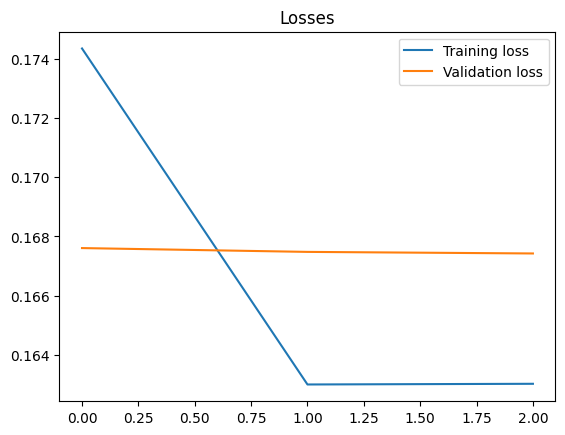

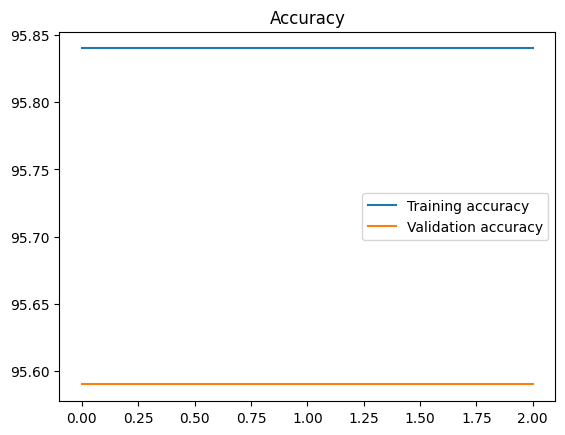

In [42]:
n_epochs = 3
learning_rate = 0.01
weight_decay = 0.01 # for L2

model = SrachNet2()
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCEWithLogitsLoss() # multilabel multiclass
#loss_fn = nn.BCELoss()
 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(trainloader, validloader, n_epochs)
opt.plot_losses()


In [43]:
preds, reals = opt.evaluate(testloader)
get_accuracy(preds, reals, ifprint=True)

toxics: 90.45 %
obscene: 94.25 %
threat: 99.68 %
insult: 94.57 %
identity_hate: 98.88 %
avg: 95.57 %


95.57

## Архитектура 3

In [45]:
class SrachNet3(nn.Module):
    def __init__(self):
        self.hidden_size = 16
        self.num_layers = 25
        self.dropout_prop = 0.2
        self.vect_num = 4
        
        super(SrachNet3, self).__init__()
        self.em1  = nn.Embedding(num_embeddings, self.vect_num).to(device)
        # После Embedding каждый токен будет представляться как вектор в vect_num-ом пространстве
        
        self.gru2 = nn.GRU(
            input_size=self.vect_num, hidden_size=self.hidden_size, num_layers=self.num_layers, 
            batch_first=True, dropout=self.dropout_prop
        ).to(device) # if batch_first=True expect input in=(N,L,Hin), h=(num_layers,N,Hout)
        #              N=batch_size, L=sequence_length, Hin=input_size, Hout=hidden_size
        #              if batch_first=True output (N, L, Hout)   (В данном примере L=25)
        #        https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        
        self.dance4 = nn.Linear(self.hidden_size, 5).to(device)
                      # 5 = len([toxics, obscene, threat, insult, identity_hate])

    def forward(self, sentence):
        batch_size = sentence.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(device)
        
        # sentence - лист c batch_size, где каждый элемент - это список токенов слов
        embeds = self.em1(sentence)
        # embeds - лист c batch_size, где каждый элемент - это список векторов слов
        
        out, h0 = self.gru2(embeds, h0.detach()) # detach <-> will never require gradient.
        # embeds.shape = (batch_size, 25, self.vect_num)
        # h0.shape = (self.num_layers, batch_size, self.hidden_size)
        # out.shape = (batch_size, 25, self.hidden_size)

        out_s = out[:, -1, :]
        # out_s.shape = (batch_size, self.hidden_size)
        # (batch_size, 25, self.hidden_size) -> (batch_size, self.hidden_size), где hidden_size последний слой rnn
        
        x = self.dance4(out_s)
        return x

    def compute_l1_loss(self, w): # Так или Адомом. Правда у него только L2...
        return torch.abs(w).sum()
    def compute_l2_loss(self, w): # Так или Адомом
        return torch.square(w).sum()


In [46]:
dsloaders_init(128)

(1/3) train: (loss: 0.3887542961608796, accur: 95.93), val: (loss: 0.2071133255958557, accur: 95.64)
(2/3) train: (loss: 0.18330572708731607, accur: 95.93), val: (loss: 0.17830671887648733, accur: 95.64)
(3/3) train: (loss: 0.1683402255887077, accur: 95.93), val: (loss: 0.17165334342341673, accur: 95.64)


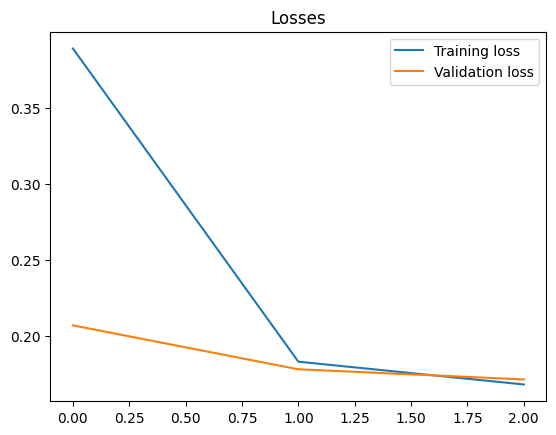

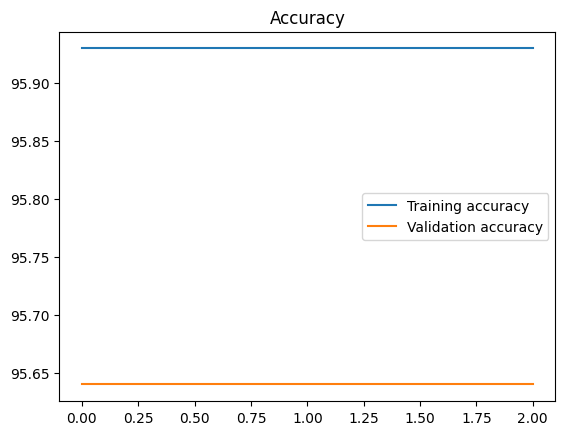

In [47]:
n_epochs = 3
learning_rate = 0.001
weight_decay = 0.01 # for L2

model = SrachNet3()
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCEWithLogitsLoss() # multilabel multiclass
#loss_fn = nn.BCELoss()
 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(trainloader, validloader, n_epochs)
opt.plot_losses()


In [48]:
preds, reals = opt.evaluate(testloader)
get_accuracy(preds, reals, ifprint=True)

toxics: 90.55 %
obscene: 94.52 %
threat: 99.69 %
insult: 94.9 %
identity_hate: 99.02 %
avg: 95.74 %


95.74

## Архитектура 4

In [18]:
class SrachNet4(nn.Module):
    def __init__(self):
        self.cnn_out_size = 32
        self.max_tokens = 25
        self.dropout_prop = 0.2
        self.vect_num = 4
        
        super(SrachNet4, self).__init__()
        self.em1  = nn.Embedding(num_embeddings, self.vect_num).to(device)
        # После Embedding каждый токен будет представляться как вектор в vect_num-ом пространстве
        
        self.conv2 = nn.Conv1d(
            in_channels=self.vect_num, out_channels=self.cnn_out_size, kernel_size=7, padding="same"
        ).to(device)
        
        self.dance4 = nn.Linear(self.cnn_out_size, 5).to(device)
                      # 5 = len([toxics, obscene, threat, insult, identity_hate])

    def forward(self, sentence):
        batch_size = sentence.size(0)
        
        # sentence - лист c batch_size, где каждый элемент - это список токенов слов
        embeds = self.em1(sentence)
        # embeds - лист c batch_size, где каждый элемент - это список векторов слов
        
        x = embeds.reshape(len(embeds), self.vect_num, self.max_tokens)
        
        x = F.relu(self.conv2(x))

        x, _ = x.max(dim=-1)
        
        x = self.dance4(x)
        return x

    def compute_l1_loss(self, w): # Так или Адомом. Правда у него только L2...
        return torch.abs(w).sum()
    def compute_l2_loss(self, w): # Так или Адомом
        return torch.square(w).sum()


In [19]:
dsloaders_init(128)

(1/10) train: (loss: 0.23519671549196958, accur: 95.49), val: (loss: 0.1747729202111562, accur: 95.37)
(2/10) train: (loss: 0.17057824323371965, accur: 95.8), val: (loss: 0.17974210267975216, accur: 95.37)
(3/10) train: (loss: 98.65108854951096, accur: 95.06), val: (loss: 0.9540620637791497, accur: 95.05)
(4/10) train: (loss: 0.23107282641996332, accur: 95.72), val: (loss: 0.1815058288120088, accur: 95.37)
(5/10) train: (loss: 0.1681372899486094, accur: 95.8), val: (loss: 0.17800702303647994, accur: 95.37)
(6/10) train: (loss: 0.16832737671274717, accur: 95.8), val: (loss: 0.18035038347755158, accur: 95.37)
(7/10) train: (loss: 0.16878851917730708, accur: 95.8), val: (loss: 0.1801481279588881, accur: 95.37)
(8/10) train: (loss: 0.16907655526788867, accur: 95.8), val: (loss: 0.18105445419039046, accur: 95.37)
(9/10) train: (loss: 0.16922056514795134, accur: 95.8), val: (loss: 0.18469167401393255, accur: 95.37)
(10/10) train: (loss: 0.16933121765349188, accur: 95.8), val: (loss: 0.184538

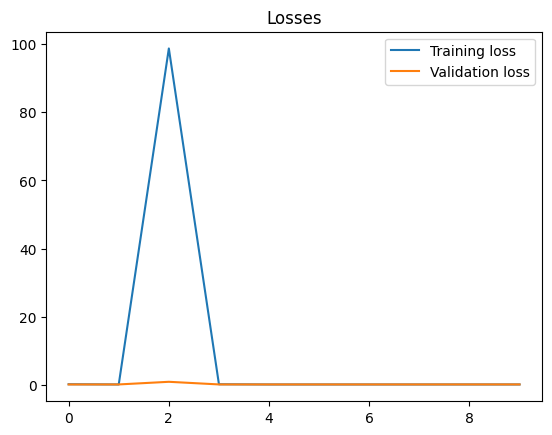

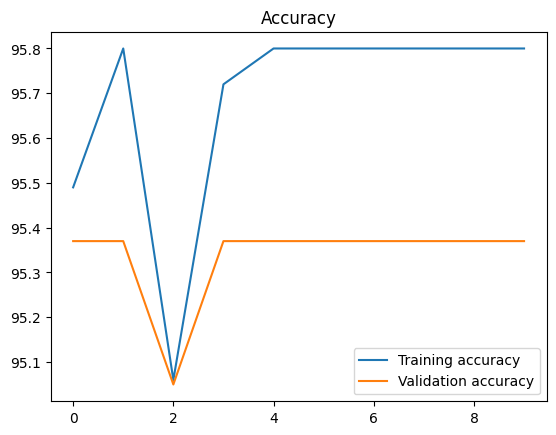

In [20]:
n_epochs = 3
learning_rate = 0.001
weight_decay = 0.01 # for L2

model = SrachNet4()
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCEWithLogitsLoss() # multilabel multiclass
#loss_fn = nn.BCELoss()
 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(trainloader, validloader, n_epochs)
opt.plot_losses()


In [25]:
preds, reals = opt.evaluate(testloader)
get_accuracy(preds, reals, ifprint=True)

toxics: 90.47 %
obscene: 94.29 %
threat: 99.67 %
insult: 94.62 %
identity_hate: 98.9 %
avg: 95.59 %


95.59

## Архитектура 5

In [21]:
class SrachNet5(nn.Module):
    def __init__(self):
        self.hidden_size = 16
        self.num_layers = 25
        self.dropout_prop = 0.2
        self.vect_num = 4
        self.hidden_size2 = 25
        self.num_layers2 = 5
        
        super(SrachNet5, self).__init__()
        self.em1  = nn.Embedding(num_embeddings, self.vect_num).to(device)
        # После Embedding каждый токен будет представляться как вектор в vect_num-ом пространстве
        
        self.rnn2 = nn.RNN(
            input_size=self.vect_num, hidden_size=self.hidden_size, num_layers=self.num_layers, 
            batch_first=True, dropout=self.dropout_prop
        ).to(device)

        self.rnn3 = nn.RNN(
            input_size=self.hidden_size, hidden_size=self.hidden_size2, num_layers=self.num_layers2, 
            batch_first=True, dropout=self.dropout_prop
        ).to(device)
        
        self.dance4 = nn.Linear(self.hidden_size2, 5).to(device)

    def forward(self, sentence):
        batch_size = sentence.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(device)
        
        embeds = self.em1(sentence)
        
        out, h0 = self.rnn2(embeds, h0.detach())
        
        h01 = torch.zeros(self.num_layers2, batch_size, self.hidden_size2).requires_grad_().to(device)
        out2, h01 = self.rnn3(out, h01.detach())
        
        out_s2 = out2[:, -1, :]
        
        x = self.dance4(out_s2)
        return x

    def compute_l1_loss(self, w): # Так или Адомом. Правда у него только L2...
        return torch.abs(w).sum()
    def compute_l2_loss(self, w): # Так или Адомом
        return torch.square(w).sum()


In [8]:
dsloaders_init(256)

(1/3) train: (loss: 0.6876878528683273, accur: 80.29), val: (loss: 0.6962260318373492, accur: 94.85)
(2/3) train: (loss: 0.5797821746932136, accur: 95.1), val: (loss: 0.6296526850340609, accur: 95.86)
(3/3) train: (loss: 0.6496810184584724, accur: 95.92), val: (loss: 0.6503837497648365, accur: 95.86)


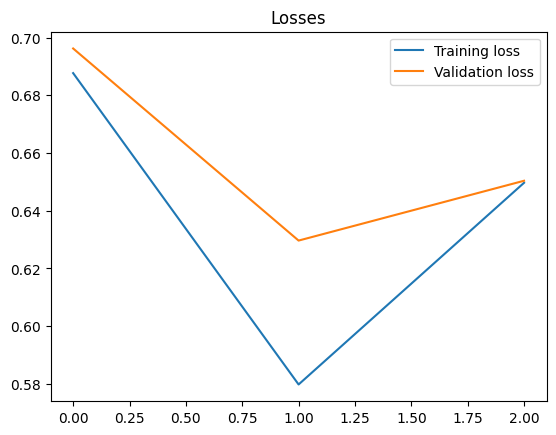

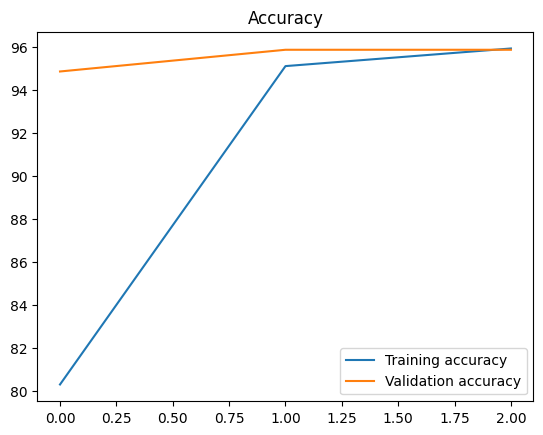

In [22]:
n_epochs = 3
learning_rate = 0.01
weight_decay = 0.01 # for L2

model = SrachNet5()
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCEWithLogitsLoss() # multilabel multiclass
#loss_fn = nn.BCELoss()
 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(trainloader, validloader, n_epochs)
opt.plot_losses()


In [23]:
preds, reals = opt.evaluate(testloader)
get_accuracy(preds, reals, ifprint=True)

toxics: 90.43 %
obscene: 94.34 %
threat: 99.67 %
insult: 94.74 %
identity_hate: 98.92 %
avg: 95.62 %


95.62